# Predicting Temperature and Weather Disposition
##### Will Strauss

### Importing Libraries

In [71]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from datetime import datetime
import pandas as pd
import numpy as np
from plotnine import *

### Importing Data

In [72]:
humidities = pd.read_csv('Weather Data/humidities.csv')
pressures = pd.read_csv('Weather Data/pressures.csv')
temperatures = pd.read_csv('Weather Data/temperatures.csv')
descriptions = pd.read_csv('Weather Data/WeatherDescription.csv')
wind_directions = pd.read_csv('Weather Data/winddirections.csv')
wind_speeds = pd.read_csv('Weather Data/windspeeds.csv')
July4Test = pd.read_csv('Weather Data/July4test.csv')

# Exploring Data

### Checking temperature trends

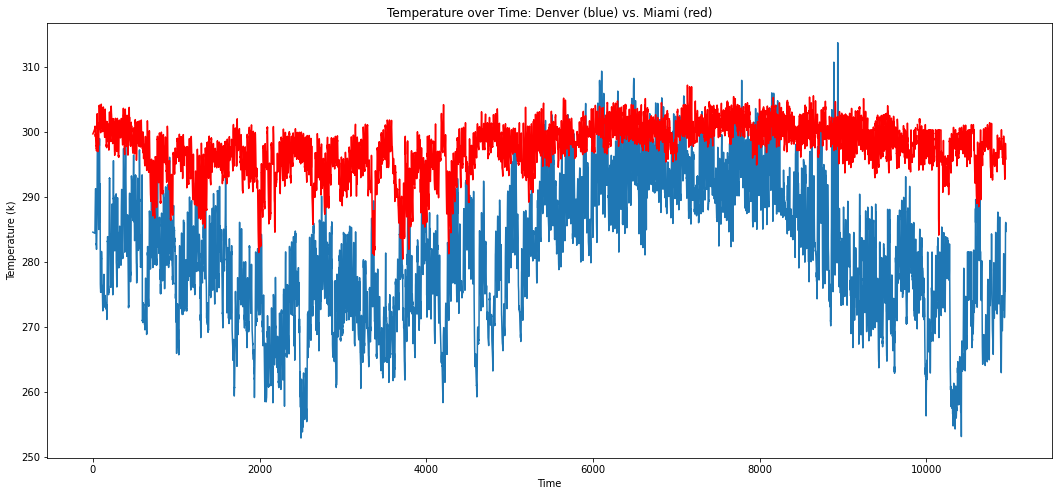

In [73]:
plt.figure(figsize = (18,8))
plt.plot(temperatures['Denver']) #Use Atlanta for a sample
plt.plot(temperatures['Miami'], color = 'red') #Use Miami for a sample
plt.title('Temperature over Time: Denver (blue) vs. Miami (red)')
plt.ylabel('Temperature (k)')
plt.xlabel('Time')
plt.show()

Temperature trend shows clear changes by season. Temperature in Denver is affected more by seasons that Miami. Miami has a higher average temperature than Denver.

Seasons and City have a clear effect on temperature. They will be good variables to create in order to help predict temperature.

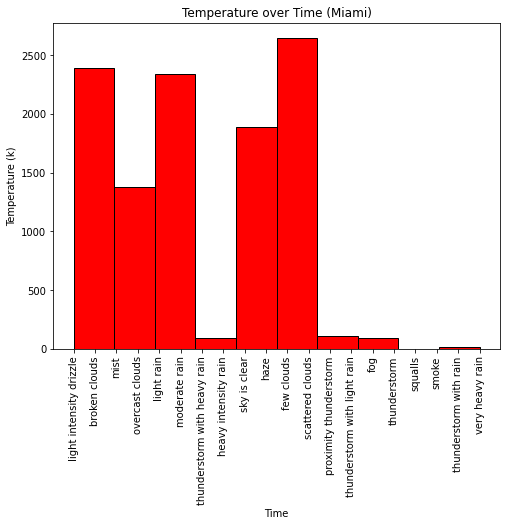

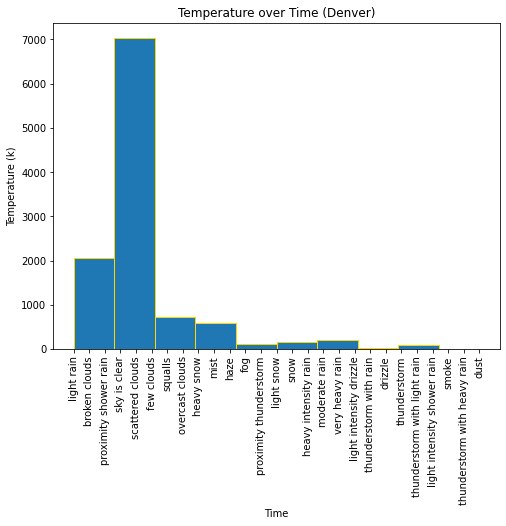

In [74]:
fig1 = plt.figure(figsize = (8,6))
plt.hist(descriptions['Miami'], color = 'red', edgecolor = 'black') #Use Miami for a sample
plt.title('Temperature over Time (Miami)')
plt.ylabel('Temperature (k)')
plt.xlabel('Time')
plt.xticks(rotation = 90)
fig1.show()

fig2 = plt.figure(figsize = (8,6))
plt.hist(descriptions['Denver'], edgecolor = 'gold') #Use Denver for a sample
plt.title('Temperature over Time (Denver)')
plt.ylabel('Temperature (k)')
plt.xlabel('Time')
plt.xticks(rotation = 90)
fig2.show()

# Processing Data

### Combining datasets into a single dataframe 

In [75]:
df = pd.DataFrame()
df2 = pd.DataFrame() #temporary dataframe for pd.concat

cities = ['Los Angeles', 'Denver', 'Atlanta', 'Jacksonville', 'Miami']

#combines all datasets and adds a city label 
for i in cities:
    df2['datetime'] = humidities['datetime']
    df2['humidities'] = humidities[i]
    df2['pressures'] = pressures[i]
    df2['temperatures'] = temperatures[i]
    df2['descriptions'] = descriptions[i]
    df2['wind_directions'] = wind_directions[i]
    df2['wind_speeds'] = wind_speeds[i]
    df2['city'] = i
    #concatenates temporary df2 into df
    df = pd.concat([df, df2])
    
#organizing data
df = shuffle(df)
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)
df

,datetime,humidities,pressures,temperatures,descriptions,wind_directions,wind_speeds,city
0,8/18/2013 16:00,71.0,1021.0,299.850,overcast clouds,130.0,5,Miami
1,12/8/2012 3:00,78.0,1015.0,294.080,few clouds,0.0,0,Miami
2,12/12/2012 21:00,NaN,1013.0,300.170,broken clouds,23.0,0,Miami
3,8/20/2013 5:00,98.0,1019.0,297.150,overcast clouds,120.0,3,Atlanta
4,4/30/2013 7:00,69.0,1017.0,297.160,broken clouds,120.0,4,Miami
...,...,...,...,...,...,...,...,...
54365,12/10/2012 3:00,85.0,1010.0,270.510,mist,30.0,6,Denver
54366,7/26/2013 10:00,92.0,1018.0,298.030,few clouds,192.0,1,Jacksonville
54367,3/12/2013 21:00,87.0,1010.0,287.460,heavy intensity rain,0.0,0,Atlanta
54368,2/4/2013 12:00,55.0,1020.0,287.930,sky is clear,0.0,0,Los Angeles


### Creating new variables for dataset

In [76]:
#seasonal variables
df['summer'] = 0
df['winter'] = 0
df['fall'] = 0
df['spring'] = 0
#many other variables in the dataset such as temperature are affected by season

#looping through dataframe to add new variables
for i in range(len(df)):
    #adding seasonal variables
    month = df['datetime'].iloc[i][:2] #indexs the month (first 2 characters in datetime), matches it with season
    if month == '3/' or month == '4/' or month == '5/':
        df['spring'].iloc[i] = 1
    elif month == '6/' or month == '7/' or month == '8/':
        df['summer'].iloc[i] = 1    
    elif month == '9/' or month == '10' or month == '11':
        df['fall'].iloc[i] = 1        
    elif month == '12' or month == '1/' or month == '2/':
        df['winter'].iloc[i] = 1

In [77]:
df = pd.get_dummies(df, columns = ['city'])
df.head()

,datetime,humidities,pressures,temperatures,descriptions,wind_directions,wind_speeds,summer,winter,fall,spring,city_Atlanta,city_Denver,city_Jacksonville,city_Los Angeles,city_Miami
0,8/18/2013 16:00,71.0,1021.0,299.85,overcast clouds,130.0,5,1,0,0,0,0,0,0,0,1
1,12/8/2012 3:00,78.0,1015.0,294.08,few clouds,0.0,0,0,1,0,0,0,0,0,0,1
2,12/12/2012 21:00,NaN,1013.0,300.17,broken clouds,23.0,0,0,1,0,0,0,0,0,0,1
3,8/20/2013 5:00,98.0,1019.0,297.15,overcast clouds,120.0,3,1,0,0,0,1,0,0,0,0
4,4/30/2013 7:00,69.0,1017.0,297.16,broken clouds,120.0,4,0,0,0,1,0,0,0,0,1


### Dropping null values

In [78]:
print(np.sum(df.isnull())) #sum of null values in each variable
df.dropna(inplace = True)

datetime                0
humidities           2491
pressures             741
temperatures           19
descriptions            0
wind_directions         3
wind_speeds             0
summer                  0
winter                  0
fall                    0
spring                  0
city_Atlanta            0
city_Denver             0
city_Jacksonville       0
city_Los Angeles        0
city_Miami              0
dtype: int64


# Exploring Data

### Correlation Matrix

<AxesSubplot:>

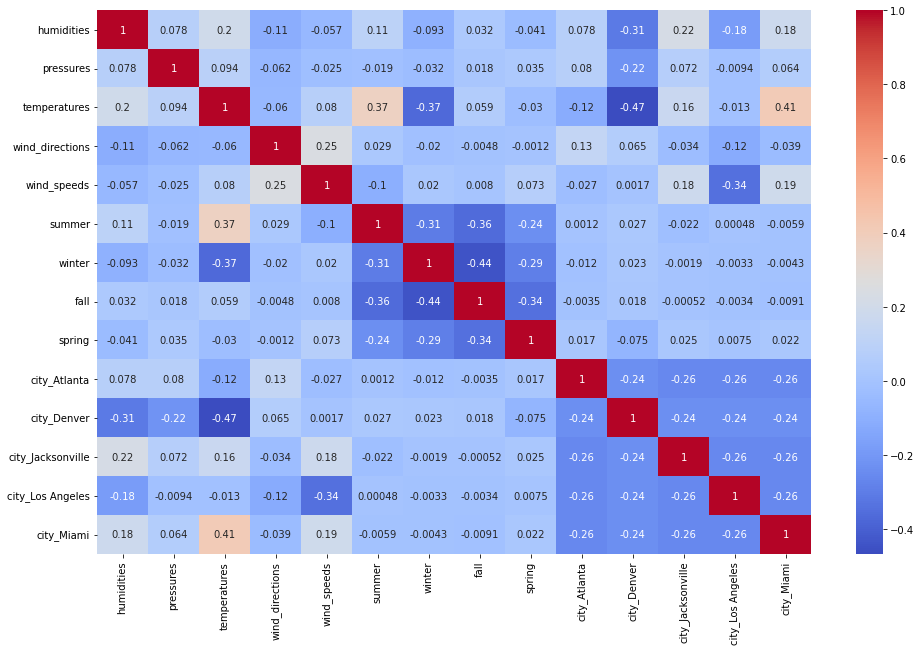

In [79]:
plt.figure(figsize = (16, 10))
seaborn.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

# Modeling Data

### Predictors

In [80]:
predictors = ['summer', 'winter', 'fall', 'spring', 'humidities', 'pressures', 'wind_directions', 'wind_speeds', 
              'city_Los Angeles', 'city_Denver','city_Atlanta', 'city_Jacksonville', 'city_Miami']

X = df[predictors]
y1 = df['descriptions'] #classification
y2 = df['temperatures'] #regression

## Linear Regression

In [81]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size = 0.2)

#zScoring 
zScore = StandardScaler()
zScore.fit(X_train)
zScore.transform(X_train) 

#fit model
LR_Model = LinearRegression()
LR_Model.fit(X_train, y_train) 

LinearRegression()

In [82]:
y_pred = LR_Model.predict(X_test)
#Output r2 and MSE values
print("Training data r2:", LR_Model.score(X_train, y_train))
print("Testing data r2:", LR_Model.score(X_test, y_test))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Training data r2: 0.5702829332187882
Testing data r2: 0.5845879973047765
Mean Squared Error: 33.6048752429356


Decent accuracy for r2, Model is not over or under fit

In [83]:
#plotting coefficients
coefficients = pd.DataFrame({"Coef": LR_Model.coef_, "Name": predictors})
coefficients = coefficients.append({"Coef": LR_Model.coef_, "Name": "Intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,6.89579,summer
1,-5.69376,winter
2,0.586488,fall
3,-1.78852,spring
4,-0.0339084,humidities
5,-0.00695629,pressures
6,-0.00286086,wind_directions
7,0.13656,wind_speeds
8,-0.130943,city_Los Angeles
9,-9.37169,city_Denver


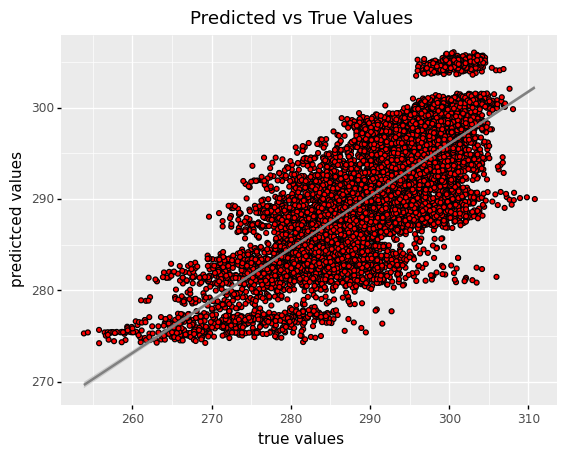

<ggplot: (8778962860508)>


In [84]:
#creating a dataframe with preicted and true values 
true_vs_pred = pd.DataFrame({"predictced values": y_pred, "true values": y_test })

#graphing true values vs predicted values
print(ggplot(true_vs_pred, aes(x = "true values", y = "predictced values")) + 
      geom_point(color = "black", fill = "red") + 
      geom_smooth(method = "lm", color = 'grey') +
      ggtitle("Predicted vs True Values"))

Graph shows a good linear trend  

## K-Nearest Neighbor Classification

In [85]:
knn = KNeighborsClassifier(n_neighbors = 25)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.2)

#zScore variables
z = StandardScaler()
Xz_train = z.fit_transform(X_train)
Xz_test = z.transform(X_test)

#fit model
knn.fit(Xz_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [86]:
#accuracy score
print('Training data accuracy', knn.score(Xz_train, y_train))
print('Testing data accuracy:',knn.score(Xz_test, y_test))

Training data accuracy 0.5033273424976927
Testing data accuracy: 0.4603652613172722


Relativley low accuracy for classification, model is slightly overfit

# Predicting New Data

### Reformatting Testing Dataset

In [87]:
#raw testing dataset
July4Test

,datetime,Los Angeles,Denver,Atlanta,Jacksonville,Miami,Reading
0,7/4/2014 13:00,100,56,72,78,70,humidity
1,7/4/2014 13:00,1014,1059,1020,1020,1021,pressure
2,7/4/2014 13:00,45,233,0,240,140,wind direction
3,7/4/2014 13:00,0,1,1,2,2,wind speed


In [88]:
#dropping datetime column
datetime = July4Test['datetime']
July4Test.drop('datetime', axis = 1, inplace = True)

In [89]:
#transposing dataframe
July4Test = July4Test.T.reset_index().reindex(columns=['index',0,1,2,3])
July4Test.drop([5], axis = 0, inplace = True)
July4Test.rename(columns={'index': 'city', 0: 'humidities', 1: 'pressures', 2: 'wind_directions', 3: 'wind_speeds'}, inplace=True)

#Adding new data

#adding dummy variables
July4Test = pd.get_dummies(July4Test, columns = ['city'])

#adding seasonal data
July4Test['summer'] = 1
July4Test['winter'] = 0
July4Test['fall'] = 0
July4Test['spring'] = 0

#re-ordering columnns
new_cols = ['summer', 'winter', 'fall', 'spring', 'humidities', 'pressures', 'wind_directions', 'wind_speeds',
           'city_Los Angeles', 'city_Denver', 'city_Atlanta', 'city_Jacksonville', 'city_Miami']

July4Test = July4Test[new_cols]

In [90]:
#formatted testing dataset
July4Test

,humidities,pressures,wind_directions,wind_speeds,city_Atlanta,city_Denver,city_Jacksonville,city_Los Angeles,city_Miami,summer,winter,fall,spring
0,100,1014,45,0,0,0,0,1,0,1,0,0,0
1,56,1059,233,1,0,1,0,0,0,1,0,0,0
2,72,1020,0,1,1,0,0,0,0,1,0,0,0
3,78,1020,240,2,0,0,1,0,0,1,0,0,0
4,70,1021,140,2,0,0,0,0,1,1,0,0,0


### Predicting temperature and description from testing dataset

In [92]:
#predicting weather description
descript_pred = knn.predict(July4Test)
descript_pred

array(['scattered clouds', 'sky is clear', 'scattered clouds',
       'sky is clear', 'scattered clouds'], dtype=object)

In [93]:
#convert data to float for predicting continuous variables
for i in July4Test:
    July4Test[i] = July4Test[i].astype(float)

In [94]:
#predicting temperature
temp_pred = LR_Model.predict(July4Test)
temp_pred

array([296.18883678, 287.72574139, 295.94051016, 300.1701092 ,
       304.91375122])

# Outputting Results to File

In [42]:
#opening file
file = open('Weather_Predictions.txt', 'a')

#loops through list of cities and outputs the city name with corresponding predicted temperature/description
for i in range(len(cities)):
    output = (cities[i] + ':\n' + str(round(temp_pred[i], 1)) + ' °K, ' + descript_pred[i] + '\n')
    file.write(str(output + '\n'))
    
file.close() #closing file